# COVID Dashboard

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from pathlib import Path
import numpy as np
import pandas as pd
import datetime
import time

In [2]:
from src.phac import PHAC

can = PHAC()

In [3]:
def doubling_time(r):
    if r > 0:
        return f"doubling in {np.log(2) / np.log1p(r): .1f}"
    elif r == 0:
        return "stationary"
    else:
        return f"half life {-np.log(2) / np.log1p(r): .1f}"
    
def rate_to_dbl_in(nper):
    if nper == np.inf:
        return 0
    else:
        return np.expm1(np.log(2) / nper)
    
def zeros(ser):
    """
    Return the list of indices where a series intercepts the x-axis
    
    :param ser: pandas.Series
    """
    state = np.sign(ser[0])
    zeros = []
    for idx, val in ser.items():
        if np.sign(val) != state:
            if np.isnan(state):
                state = np.sign(val)
            else:
                zeros.append(idx)
                state = np.sign(val)
    return zeros

# Notes on Modeling COVID

## Introduction

The data sets available to us give us, for each location, a multi-dimensional timeseries.  Each time observation can be assumed to include the following features:

* $\tau_{t}$ - the number of individuals tested as a proportion of the population
* $\pi_{t}$ - the positivity rate.  Note $\pi \sim \frac{\nu}{\tau}$.  Depending on the reporting protocols, new cases reported at time $t$ may not be the result of tests reported at $t$.
* $\nu_{t}$ - the number of new cases as a proportion of the population
* $\delta_{t}$ - the number of deaths as a proportion of the population

We may also have

* $\rho_{t}$ the number of resolved cases as a proportion of the population
* $\eta_{t}$ the number of hospitalizations as a proportion of the population

Derived variables include:

* $T_{t} = \sum^{t}_{k=0}{\nu_{k}}$ - total cases as a proportion of the population

Note, the new cases reported at a give time, $t$, may not be the results of testing at $t$

## Processes driving disease spread

Viral spread is the result of the following processes:

* Transmission (or contagion) - this is a function of the virus
* Population immunity - this is a function of disease prgress and the state of vaccinations
* Exposure (or contact) - this is a function if population behaviour
* Resolution - this is a property of the virus and the treatment regime

### Exposure Model

We model exposure or contact by a random variable $E$ over $R_{\ge 0}$ where $P(E=x)$ is interpreted as the probability that a member of the population is exposed to viral load $x$.  The exponential distribution is a natural model for exposure. 

The exposure model varies with time and location and is affected by population behaviour.

Public health interventions aim to change population behaviour.

* Hand washing reduces exposure from fomites.
* Social distancing (maintaining distance from others) reduces exposure from droplets.
* Mask wearing reduces the amount of virus in the environment and reduces exposure from droplets in the air.  Note mask wearing may also increase exposure to fomites.
* Social isolation (reducing the number and duration of contacts) reduces exposure to the virus in all forms.  
* Testing, contact tracing, and quarantine aim to isolate eliminate reduce the viral load in social environments.
* Facility controls (e.g, ventilation) reduce viral load in environment

If we choose the exponential distribution, then the p.d.f is $P(E=x) = \lambda e^{-\lambda x)}$ and the c.d.f is $P(E \le x) = (1 - e^{-\lambda x})$

So exposure model is parameterized by a series $\{\lambda^E_t\}$ for each location.

### Transmission (Contagion Model)

We model transmission as a mixture of exponential distributions.  Only the latent mixture variable changes with time.  We have a set of strains $S$ and a family $\{C_s | s \in S\}$ of exponential distributions.  Each $C_s$ represents the probability that a susceptible member of the population is infected when exposed to a viral load $x$. (Note, we may want to consider using a logistic distribution if infection has a hard threshold).  At any point in time we have a distribution $P_t(S=s) = p_t(s)$.

So the transmission model is parameterized by $\{\lambda^S_s\}$ and $|S|$-wide series $<p_t(s)>$ at each location

### Immunity Model

Acquired population immunity changes the transmission model.  If an individual has some degree of immunity then the transmission threshold for that individual increases.

Immunity is a function of how the individual acquired (i.e., infection, vaccine type, vaccine dosage) and potentially the time since it was acquired (e.g., after a vaccine immunity increases for a period and then diminishes with time).    Let $\theta$ be the effectiveness of an individual's immunity.  This means that under equivalent exposure scenarios $P(\text{infection} | \text{immunity}) = (1-\theta)\ P(\text{infection} | \text{no immunity})$. 

Let $I_{s,t}$ be the random variable over the sample space $[0,1]$ representing population immunity at $t$ for strain $s$; that is $p_{I_{s,t}}(\theta)$ is the probability that a random individual has immunity with effectiveness $\theta$.  The contagion (transmission) for strain $s$ at $t$ is modelled by the scale mixture (compound random variable) $C_{s,t}(\lambda_s, I_{s,t})$.  The pdf for $C_{s,t}$ is goven by:

$$p_{C_{s,t}}(x) = \int{ \lambda_{s, \theta} e^{-\lambda_{s,\theta} x} p_{I_{s,t}}(\theta) d \theta}$$

where $\lambda_{s,\theta} = \frac{\lambda_s}{1 - \theta}$. Need to prove this is well defined for reasonable immunity models.


### Resolution Model.

Infections resolve after a period of time.  Either the infected individual recovers and is no longer infectious or the infected individual dies and is no longer infectious.  We assume that resolution is independent of time and virus strain.  Resolution can be assumed to follow a poisson distribution $r(n;\lambda)$ representing the probability that a case resolves after $n$ time periods. Let $Res$ be the random variable representing the resolution model.

## Growth Model for a Single Location

Transmission rate at time $t$ is given by

$$ R_t = \sum_{s \in S}{p_t(s) \int_{x}{P_t(E=x) P(C_s=x)} dx} = \sum_{s \in S}{ p_t(s) \frac{\lambda^E_t \lambda^S_s}{\lambda^E_t + \lambda^S_s} }$$

Let $\alpha_t(k)$ be the active cases of age $k$ at time $t$ as a proportion of the population, and let $\alpha_t = \sum_{k}{\alpha_t(k)}$.  We have,

$$\alpha_{t+1}(k+1) = \alpha_t(k) Prob(Res > k) \text{ and } \alpha_{t+1}(0) = \alpha_t R_t$$
 



## Estimating True Incidence

Let $\eta_t$ be the incidence rate (proportion of the population) infected at time $t$.  


In [4]:

fit_win = 14
meas_win = 7
tests = can.var_by_location("new_tests_rate", *can.provinces, ma_window=1)*1000
cases = can.var_by_location("new_cases_rate", *can.provinces, ma_window=1)
deaths = can.var_by_location("new_deaths_rate", *can.provinces, ma_window=meas_win).fillna(0)
posrate = can.pos_test_rate(meas_win, *can.provinces)
posgrowth = can.growth_rate("pos_test_rate", meas_win, *can.provinces)
new_cases_abs = can.var_by_location("new_cases", *can.provinces, ma_window=1)
new_cases_abs[can.provinces][-7:]

location,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2021-09-18,4536.0,0.0,3.0,0.0,63.0,821.0,821.0,54.0,493.0,1605.0,644.0,3.0,29.0,0.0
2021-09-19,4336.0,0.0,3.0,0.0,75.0,742.0,715.0,51.0,543.0,1592.0,613.0,0.0,0.0,2.0
2021-09-20,3853.0,15.0,0.0,55.0,61.0,679.0,610.0,39.0,516.0,1436.0,442.0,0.0,0.0,0.0
2021-09-21,3809.0,16.0,3.0,25.0,65.0,587.0,574.0,54.0,372.0,1519.0,525.0,9.0,58.0,2.0
2021-09-22,3879.0,23.0,0.0,19.0,76.0,683.0,463.0,67.0,426.0,1336.0,759.0,0.0,27.0,0.0
2021-09-23,4599.0,0.0,0.0,41.0,52.0,754.0,677.0,63.0,460.0,1660.0,861.0,13.0,18.0,0.0
2021-09-24,4609.0,45.0,6.0,34.0,78.0,701.0,727.0,60.0,527.0,1651.0,743.0,7.0,30.0,0.0


In [5]:
100000 * cases[can.provinces][-7:]

location,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2021-09-18,11.935189,0.000000,1.879431e+00,2.710505e-15,8.061709,9.574820,5.572136,3.915131,41.826435,36.296838,12.510399,7.134008,64.214673,2.710505e-14
2021-09-19,11.408949,0.000000,1.879437e+00,2.710505e-15,9.597333,8.653503,4.852722,3.697626,46.068480,36.002829,11.908197,0.000000,0.000000,5.082209e+00
2021-09-20,10.138076,2.873025,3.388132e-16,5.615926e+00,7.805728,7.918757,4.140084,2.827598,43.777718,32.474888,8.586343,0.000000,0.000000,2.710505e-14
2021-09-21,10.022297,3.064515,1.879443e+00,2.552722e+00,8.317624,6.845824,3.895745,3.915131,31.560676,34.351962,10.198715,21.402124,128.429393,5.082202e+00
2021-09-22,10.206491,4.405308,3.388132e-16,1.940069e+00,9.725110,7.965421,3.142385,4.857665,36.142118,30.213428,14.744409,0.000000,59.786223,2.710505e-14
2021-09-23,12.100964,0.000000,3.388132e-16,4.186423e+00,6.654109,8.793445,4.594811,4.567658,39.026652,37.540633,16.725890,30.914106,39.857324,2.710505e-14
2021-09-24,12.127284,8.619105,3.758908e+00,3.471711e+00,9.981138,8.175329,4.934157,4.350150,44.710961,37.337116,14.433593,16.646094,66.428912,2.710505e-14


In [6]:
pt_1day = can.pos_test_rate(1, *can.provinces)

pt_tests_dict = {}
for loc in can.provinces:
    a = (100*pt_1day[loc]).apply(lambda x: f"{x:.2f}")
    b = tests[loc].apply(lambda x: f"{x:.2f}")
    pt_tests_dict[loc] = a + " / " + b

pt_tests_df = pd.DataFrame(pt_tests_dict)
pt_tests_df[-7:]

,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2021-09-18,3.95 / 3.02,0.00 / 2.66,0.22 / 8.44,0.00 / 4.26,3.08 / 2.62,2.48 / 3.85,2.43 / 2.29,1.54 / 2.54,11.03 / 3.79,9.26 / 3.92,4.73 / 2.64,inf / 0.00,14.80 / 4.34,0.00 / 1.02
2021-09-19,4.23 / 2.69,0.00 / 2.21,0.31 / 6.05,0.00 / 3.26,4.69 / 2.05,2.59 / 3.34,2.33 / 2.08,1.78 / 2.08,13.88 / 3.32,9.70 / 3.71,4.83 / 2.46,nan / 0.00,0.00 / 4.01,1.75 / 2.90
2021-09-20,3.99 / 2.54,1.38 / 2.08,0.00 / 3.83,2.05 / 2.74,4.63 / 1.69,2.72 / 2.91,2.04 / 2.03,1.50 / 1.89,13.10 / 3.34,8.69 / 3.74,3.50 / 2.45,nan / 0.00,0.00 / 2.72,0.00 / 0.66
2021-09-21,4.58 / 2.19,2.01 / 1.53,0.46 / 4.07,0.91 / 2.80,3.01 / 2.77,2.48 / 2.77,2.41 / 1.62,2.18 / 1.80,9.94 / 3.17,11.35 / 3.03,5.43 / 1.88,inf / 0.00,inf / 0.00,4.44 / 1.14
2021-09-22,4.28 / 2.38,1.79 / 2.47,0.00 / 5.55,0.64 / 3.05,3.40 / 2.86,2.31 / 3.45,1.96 / 1.60,2.81 / 1.73,11.97 / 3.02,9.83 / 3.07,7.42 / 1.99,nan / 0.00,17.88 / 3.34,0.00 / 2.34
2021-09-23,3.93 / 3.08,0.00 / 3.09,0.00 / 6.75,0.96 / 4.34,2.55 / 2.61,2.41 / 3.64,1.73 / 2.65,2.03 / 2.25,11.87 / 3.29,11.43 / 3.28,5.43 / 3.08,inf / 0.00,12.08 / 3.30,0.00 / 2.29
2021-09-24,3.64 / 3.34,2.31 / 3.73,0.91 / 4.11,0.77 / 4.49,3.00 / 3.33,1.94 / 4.22,1.93 / 2.55,1.77 / 2.45,13.32 / 3.36,9.23 / 4.05,4.14 / 3.49,inf / 0.00,22.22 / 2.99,0.00 / 1.78


In [7]:
location = "Ontario"

In [8]:
from src.models.growth import GeometricProcess

def predict_on_growth_trend(model, k, trend_win=14):
    """
    Predict positivity rate out k time periods based on model
    """
    growth = np.exp(model["LogGrowthRate"].values)
    m = (growth[-1] - growth[-trend_win]) / trend_win
    pred_growth = np.array([growth[-1]+ m * (j+1) for j in range(k)])
    pred_log_growth = np.log(pred_growth)
    log_pt_0 = (model["PredictedLogValue"].values)[-1]
    result = log_pt_0 + np.array([np.sum(pred_log_growth[0:j+1]) for j in range(k)])
    return pred_growth, np.exp(result)
    

proc = GeometricProcess(est_per=fit_win)
proc.fit(posrate[location])

# Get sign changes in growth rate
grzeros = zeros(proc.model["LogGrowthRate"])

x = [idx.date() for idx in proc.model.index]
x_shifted = proc.model.index - proc.est_per * pd.Timedelta("1 day")

model = np.exp(proc.model)
model.columns = ["Growth Rate", "Prior Positivity Rate", "Error", "Predicted Positivity Rate", "Measured Positivity Rate"]
model[-14:]

,Growth Rate,Prior Positivity Rate,Error,Predicted Positivity Rate,Measured Positivity Rate
2021-09-11,1.008152,0.027966,1.003842,0.031079,0.030426
2021-09-12,1.007236,0.028282,1.005268,0.031061,0.030261
2021-09-13,1.005670,0.028745,1.006232,0.030937,0.030154
2021-09-14,1.004252,0.029167,1.006423,0.030821,0.030246
2021-09-15,1.002623,0.029577,1.007190,0.030602,0.029761
2021-09-16,0.999162,0.030304,1.008796,0.029975,0.028257
2021-09-17,0.995690,0.030916,1.012328,0.029228,0.027261
2021-09-18,0.991789,0.031545,1.014670,0.028339,0.026287
2021-09-19,0.988185,0.031983,1.018010,0.027405,0.025338
2021-09-20,0.985234,0.032160,1.021501,0.026505,0.024601


In [9]:
predict_on_growth_trend(proc.model, 45, trend_win=7)

(array([0.96890623, 0.9660459 , 0.96318558, 0.96032525, 0.95746492,
        0.95460459, 0.95174427, 0.94888394, 0.94602361, 0.94316328,
        0.94030295, 0.93744263, 0.9345823 , 0.93172197, 0.92886164,
        0.92600132, 0.92314099, 0.92028066, 0.91742033, 0.91456001,
        0.91169968, 0.90883935, 0.90597902, 0.90311869, 0.90025837,
        0.89739804, 0.89453771, 0.89167738, 0.88881706, 0.88595673,
        0.8830964 , 0.88023607, 0.87737575, 0.87451542, 0.87165509,
        0.86879476, 0.86593443, 0.86307411, 0.86021378, 0.85735345,
        0.85449312, 0.8516328 , 0.84877247, 0.84591214, 0.84305181]),
 array([0.02175787, 0.02101911, 0.0202453 , 0.01944207, 0.0186151 ,
        0.01777006, 0.01691255, 0.01604805, 0.01518184, 0.01431895,
        0.01346415, 0.01262187, 0.01179618, 0.01099076, 0.01020889,
        0.00945345, 0.00872686, 0.00803116, 0.00736795, 0.00673844,
        0.00614343, 0.00558339, 0.00505843, 0.00456837, 0.00411271,
        0.00369074, 0.0033015 , 0.00294388, 0.

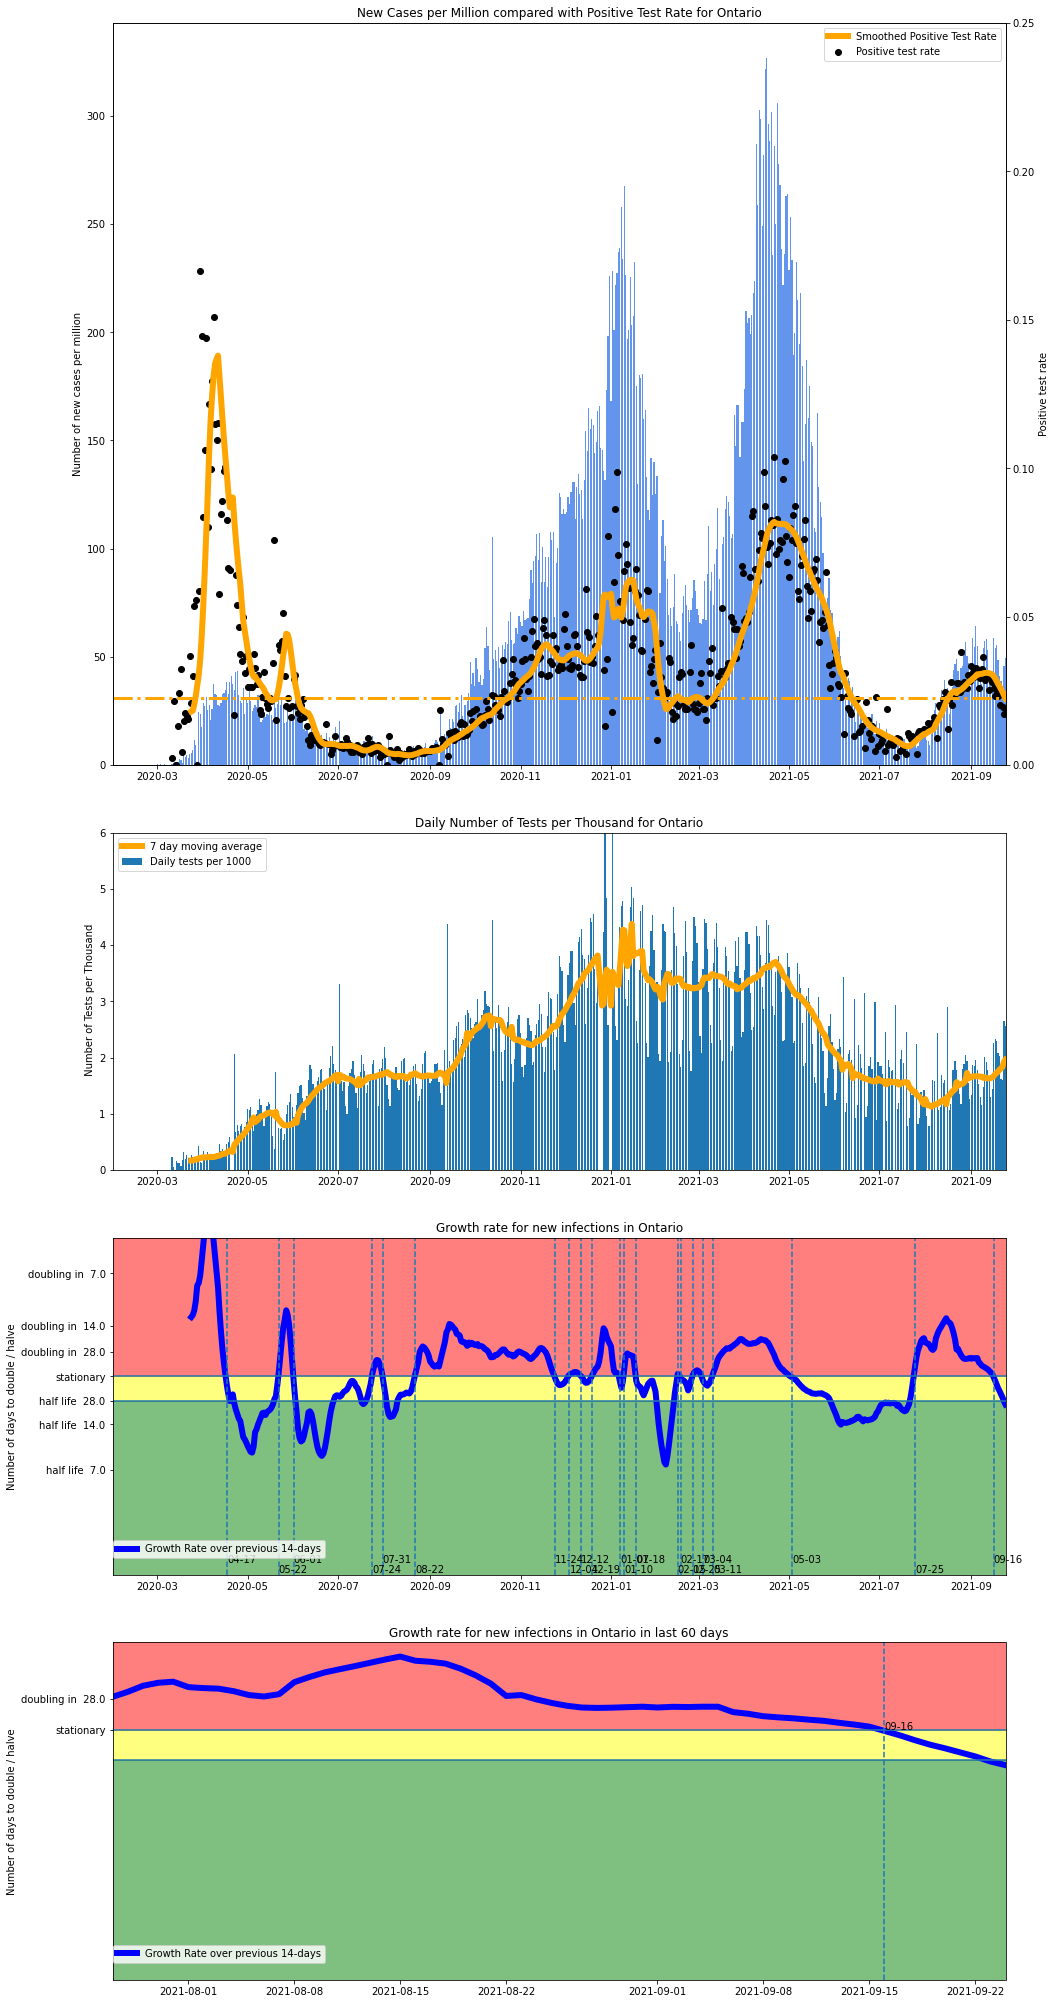

In [10]:
save_file = True
    
doubling_ticks = [-2, -3, -4, -5, -6, -7, -14, -28, np.inf, 28, 14, 7, 6, 5, 4, 3, 2]
doubling_tick_locs = [rate_to_dbl_in(nper) for nper in doubling_ticks]
doubling_tick_labels = [doubling_time(tick) for tick in doubling_tick_locs]
doubling_hlines = [rate_to_dbl_in(nper) for nper in [-28, np.inf]]


#dashboard, db_ax = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(16,24))
dashboard = plt.figure(figsize=(16,36))
db_ax = []
gs = GridSpec(5,1, figure=dashboard)
db_ax.append(dashboard.add_subplot(gs[0:2,:]))
db_ax.append(dashboard.add_subplot(gs[3,:]))
db_ax.append(dashboard.add_subplot(gs[2,:]))
db_ax.append(dashboard.add_subplot(gs[4,:]))

db_ax[0].bar(cases.index, cases[location]*1000000, color="cornflowerblue")
#db_ax[0].plot(cases.index, deaths[location], color="black")
db_ax[0].set_ylabel(f"Number of new cases per million")
db_ax0r = db_ax[0].twinx()
db_ax0r.plot(x, np.exp(proc.model["PredictedLogValue"]), 
         c="orange", lw=6, label="Smoothed Positive Test Rate")
db_ax0r.scatter(pt_1day.index, pt_1day[location], 
                c="black", label=f"Positive test rate" )
db_ax0r.set_ylim((0, 0.25))
db_ax0r.set_ylabel("Positive test rate")
db_ax[0].set_xlim((min(cases.index), max(cases.index)))
db_ax[0].set_title(f"New Cases per Million compared with Positive Test Rate for {location}")
db_ax0r.legend()

db_ax0r.axhline(y=np.exp(proc.model.iloc[-1]["PredictedLogValue"]), lw=3, linestyle="-.", c="orange")

#db_ax[1].plot(posgrowth.index, posgrowth[location], lw=6, label="Growth Rate")
#posgrowth_ma = posgrowth.rolling(14).mean()[location]
#db_ax[1].plot(posgrowth.index, posgrowth_ma, lw=6, c="orange", label="14-day moving average")
db_ax[1].plot(x, np.exp(proc.model["LogGrowthRate"])-1, lw=6,
            c="blue", label=f"Growth Rate over previous {fit_win}-days")
db_ax[1].set_xlim((min(cases.index), max(cases.index)))
db_ax[1].set_ylim( (-0.2, 0.14))
db_ax[1].set_yticks(doubling_tick_locs[5:-5])
db_ax[1].set_yticklabels(doubling_tick_labels[5:-5])
db_ax[1].set_ylabel("Number of days to double / halve")
db_ax[1].set_title(f"Growth rate for new infections in {location}")
db_ax[1].legend(loc=(0, 0.05))

for y in doubling_hlines:
    db_ax[1].axhline(y=y)

db_ax[1].axhspan(0, db_ax[1].get_ylim()[1], color="red", alpha=0.5)  # danger zone
db_ax[1].axhspan(rate_to_dbl_in(-28), 0, color="yellow", alpha=0.5)  # Time to pay attention
db_ax[1].axhspan(db_ax[1].get_ylim()[0], rate_to_dbl_in(-28), color="green", alpha=0.5)  # Comfort zone

# if location == "Ontario":
#     db_ax[1].axvline(x="2020-05-19", linestyle="-", lw=6)
#     db_ax[1].annotate("Phase 1  \nopening begins  ", 
#                       ("2020-05-19", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-06-12", linestyle="-", lw=6)
#     db_ax[1].annotate("Phase 2  \nopening begins  ", 
#                       ("2020-06-12", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-07-17", linestyle="-", lw=6)
#     db_ax[1].annotate("Phase 3  \nopening begins  ", 
#                       ("2020-07-17", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-09-23", linestyle="-", lw=6)
#     db_ax[1].annotate("Bars and restaurants  \nordered to close early  ", 
#                       ("2020-09-23", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-10-14", linestyle="-", lw=6)
#     db_ax[1].annotate("Modified Phase 2  \nPeel, Toronto, Ottawa  ", 
#                       ("2020-10-14", 0.075),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-12-26", linestyle="-", lw=6)
#     db_ax[1].annotate("Province Wide Lock Down", 
#                       ("2020-12-26", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2021-01-13", linestyle="-", lw=6)
#     db_ax[1].annotate("Emergency Stay at Home Order", 
#                       ("2021-01-13", 0.075),
#                      horizontalalignment="right")



anpos = 1
for idx in grzeros:
    db_ax[1].axvline(x=idx, linestyle="--")
    db_ax[1].annotate(str(idx.date())[-5:], (idx, 0.002 + db_ax[1].get_ylim()[0] + anpos * 0.01))
    anpos = (anpos + 1) % 2

tests_ave = can.var_by_location("new_tests_rate", location, ma_window=fit_win) * 1000
db_ax[2].bar(tests.index, tests[location], label="Daily tests per 1000")
db_ax[2].plot(tests_ave.index, tests_ave, c="orange", lw=6, label=f"{meas_win} day moving average")
db_ax[2].set_title(f"Daily Number of Tests per Thousand for {location}")
db_ax[2].set_ylabel(" Number of Tests per Thousand")
db_ax[2].set_xlim((min(tests.index), max(tests.index)))
db_ax[2].set_ylim((0, 6))
db_ax[2].legend(loc="upper left")

# zoom in on growth rate
zoom = 60
db_ax[3].plot(x[-zoom:], np.exp(proc.model[-zoom:]["LogGrowthRate"])-1, lw=6,
            c="blue", label=f"Growth Rate over previous {fit_win}-days")
db_ax[3].set_xlim( ( min(x[-zoom:]), max(x[-zoom:]) ) )
db_ax[3].set_ylim( (-0.2, 0.07))
db_ax[3].set_yticks(doubling_tick_locs[8:-7])
db_ax[3].set_yticklabels(doubling_tick_labels[8:-7])
db_ax[3].set_ylabel("Number of days to double / halve")
db_ax[3].set_title(f"Growth rate for new infections in {location} in last {zoom} days")
db_ax[3].legend(loc=(0, 0.05))

for y in doubling_hlines:
    db_ax[3].axhline(y=y)

db_ax[3].axhspan(0, db_ax[1].get_ylim()[1], color="red", alpha=0.5)  # danger zone
db_ax[3].axhspan(rate_to_dbl_in(-28), 0, color="yellow", alpha=0.5)  # Time to pay attention
db_ax[3].axhspan(db_ax[1].get_ylim()[0], rate_to_dbl_in(-28), color="green", alpha=0.5)  # Comfort zone

for idx in grzeros:
    if idx in x[-zoom:]:
        db_ax[3].axvline(x=idx, linestyle="--")
        db_ax[3].annotate(str(idx.date())[-5:], (idx, 0))

    


if save_file:
    as_of = x[-1]
    savefile = f"{as_of}_COVID_Dashboard_{location}.png"
    plt.savefig(Path.home().joinpath("Documents/COVID/" + savefile), format="png")




In [11]:
ptr = list(map(doubling_time, np.exp(proc.model["LogGrowthRate"])-1))
ptr[-10:]

['doubling in  264.6',
 'half life  827.1',
 'half life  160.5',
 'half life  84.1',
 'half life  58.3',
 'half life  46.6',
 'half life  38.1',
 'half life  32.3',
 'half life  27.1',
 'half life  24.2']

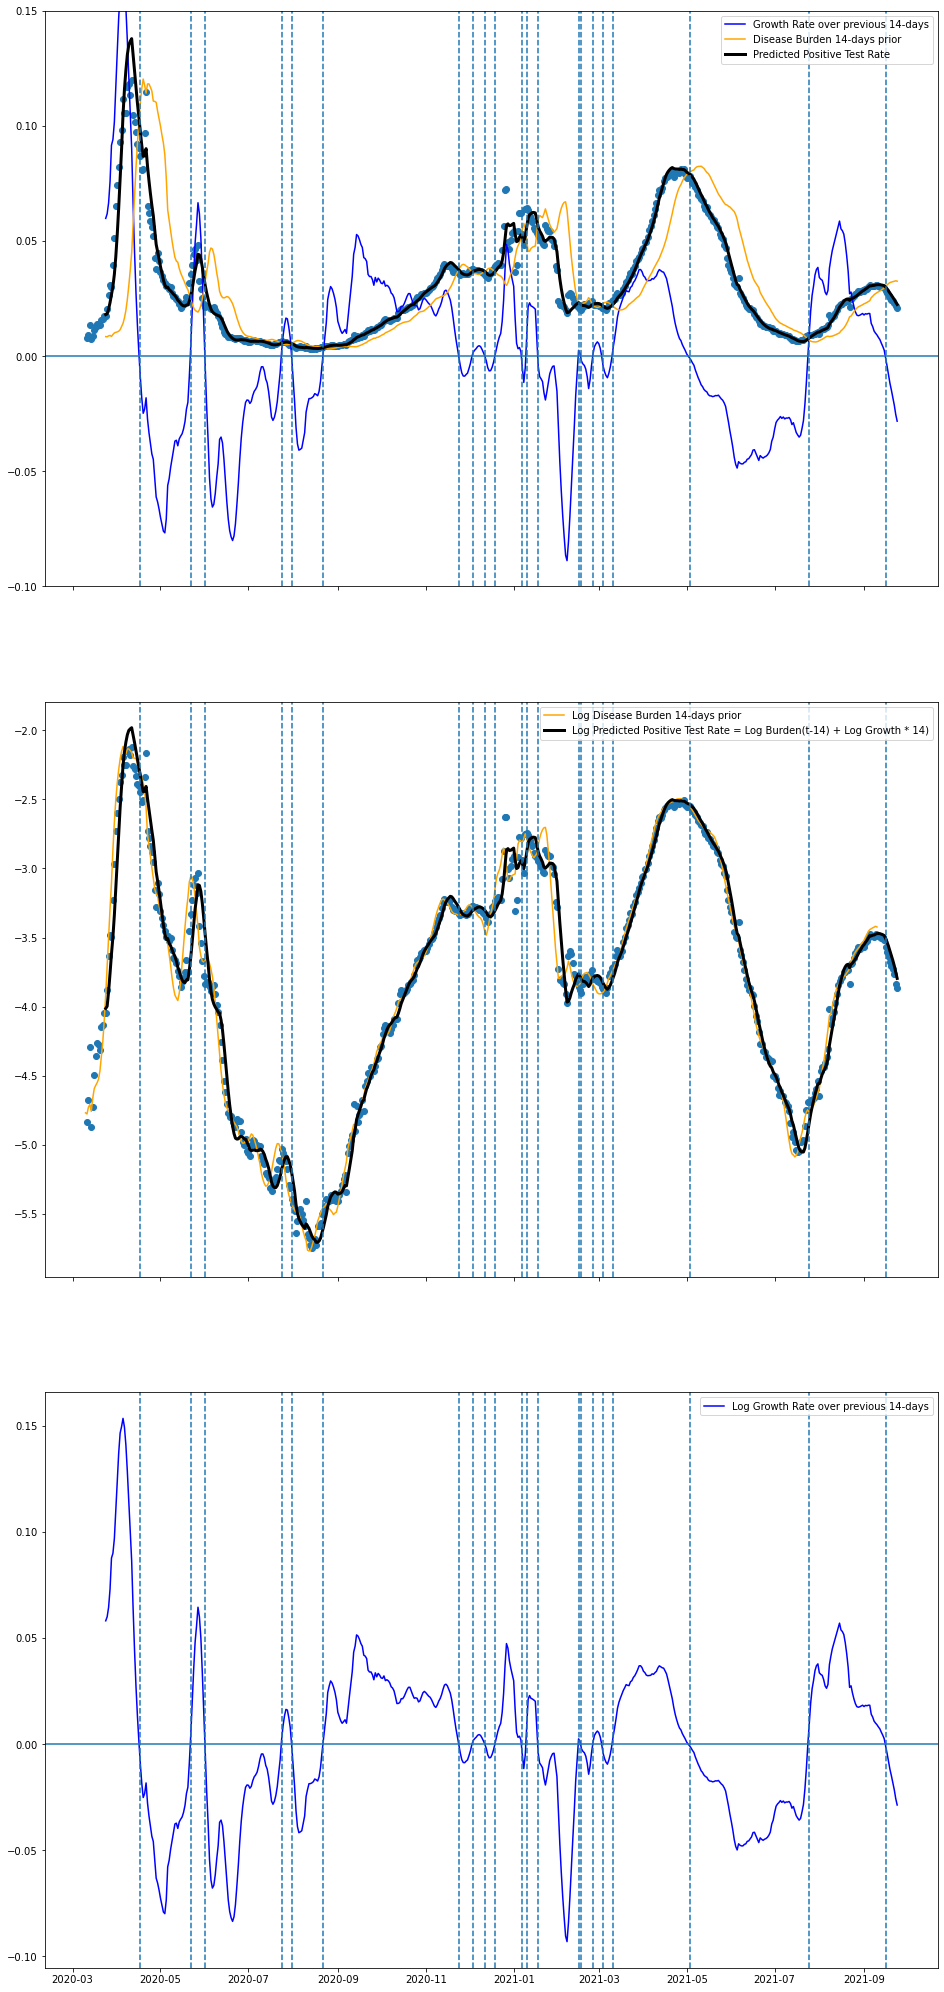

In [12]:
f1, ax1 = plt.subplots(nrows=3, ncols=1, figsize=(16,36), sharex=True)

ax1[0].plot(x, np.exp(proc.model["LogGrowthRate"])-1, 
            c="blue", label=f"Growth Rate over previous {fit_win}-days")
ax1[0].plot(x, np.exp(proc.model["LogPriorProcessLoad"]), 
         c="orange", label=f"Disease Burden {fit_win}-days prior")
ax1[0].plot(x, np.exp(proc.model["PredictedLogValue"]), 
         c="black", lw=3, label="Predicted Positive Test Rate")
ax1[0].scatter(posrate.index, posrate[location] )
ax1[0].set_ylim((-0.1, 0.15))
ax1[0].legend()

for idx in grzeros:
    ax1[0].axvline(x=idx, linestyle="--")
ax1[0].axhline(y=0)

#ax1[1].plot(posrate.index[x], [fit[0][0] for fit in fits], c="blue", label="Log Growth Rate")
ax1[1].plot(x_shifted, proc.model["LogPriorProcessLoad"], 
         c="orange", label=f"Log Disease Burden {fit_win}-days prior")
ax1[1].plot(x, proc.model["PredictedLogValue"], 
         c="black", lw=3, 
         label=f"Log Predicted Positive Test Rate = Log Burden(t-{fit_win}) + Log Growth * {fit_win})")
ax1[1].scatter(posrate.index, np.log(posrate[location]) )
#ax1[1].set_ylim((-0.1, 0.1))
ax1[1].legend()

for idx in grzeros:
    ax1[1].axvline(x=idx, linestyle="--")

ax1[2].plot(x, proc.model["LogGrowthRate"], 
            c="blue", label=f"Log Growth Rate over previous {fit_win}-days")
#ax1[2].plot(x, lgr, 
#            c="red", label=f"Log Growth Rate Core Processes")
ax1[2].legend()

ax1[2].axhline(y=0)
for idx in grzeros:
    ax1[2].axvline(x=idx, linestyle="--")